### Package Imports

In [1]:
#Package imports
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import utils
sns.set_style('darkgrid')
from pandas_datareader import data #Package for pulling data from the web
from datetime import date
from fbprophet import Prophet 

### Pulling in Data

In [2]:
#Pulling in the tickers and economic predicators we're interested in (Taiwan ETF, S&P 500, Gold, US Tech ETF, etc.)
tickers = ["EWT",'^GSPC','^N225','IYW','EXSA.MI','TWDUSD=X','CL=F','GC=F','SI=F','HG=F']

#Getting the most up to date data we can
today = date.today() #This function automatically updates with today's data


#Pulling the timeseries data directly from yahoo finance into a dataframe
etf_df= data.DataReader(tickers, 
                       start='2009-01-01', #start date
                       end = today, #charting up to today's date
                       data_source='yahoo')['Adj Close'] #obtaining price at close

#Dropping missing vals
etf_df = etf_df.dropna()

#Checking the 5 most recent values
etf_df.head(5)

Symbols,EWT,^GSPC,^N225,IYW,EXSA.MI,TWDUSD=X,CL=F,GC=F,SI=F,HG=F
Date,,,,,,,,,,
2009-01-05,11.769104,927.450012,9043.120117,33.300484,21.010000,0.030161,48.810001,857.200012,11.245,1.4420
2009-01-06,11.890592,934.700012,9080.839844,34.210724,21.600000,0.030262,48.580002,865.400024,11.420,1.5660
2009-01-07,11.617244,906.650024,9239.240234,33.066166,21.600000,0.030234,42.630001,841.099976,11.080,1.4945
2009-01-08,11.298341,909.729980,8876.419922,33.273453,21.600000,0.030184,41.700001,853.900024,11.072,1.4630
2009-01-09,10.857948,890.349976,8836.799805,32.444324,21.129999,0.030111,40.830002,854.299988,11.295,1.5455


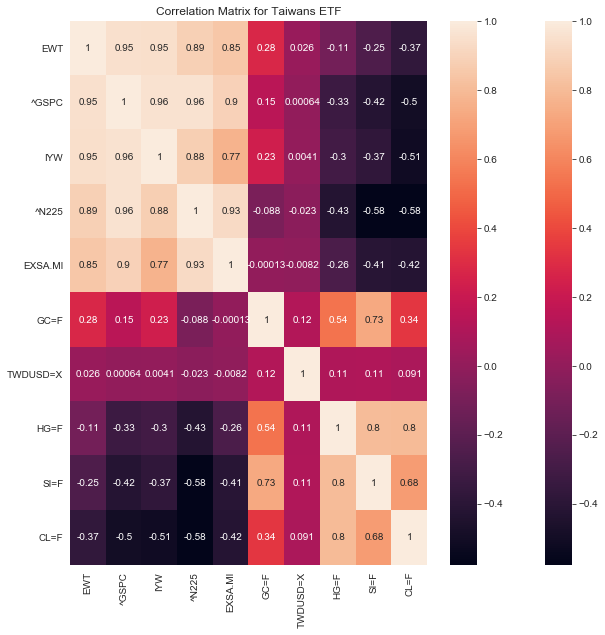

In [3]:
#Creating correlation matrix
corr_mat = etf_df.corr()
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(corr_mat)

#Quantifying the Correlation Matrix
i = 10
columns = corr_mat.nlargest(i,'EWT')['EWT'].index
corrmat = np.corrcoef(etf_df[columns].values.T)
heatmap = sns.heatmap(corrmat,
            cbar=True,
            annot=True, 
            xticklabels = columns.values,
            yticklabels = columns.values)
ax.set_title('Correlation Matrix for Taiwans ETF')
plt.show()

### Critical Predicators

From the above correlation matrix it is clear that the S&P 500, the IWY index, the Nikkei and the EXSA.MI Index are significant predicators of the value of the iShares MSCI ETF

### Forecasting Predicator Variables Individually

In [8]:
#Creating dfs to model with

#IYW
iyw_prophet = pd.DataFrame()
iyw_prophet['ds'] = etf_df.index
iyw_prophet['y'] = etf_df['IYW'].values

#^N225
n225_prophet = pd.DataFrame()
n225_prophet['ds'] = etf_df.index
n225_prophet['y'] = etf_df['^N225'].values

#EXSA.MI
exsa_prophet = pd.DataFrame()
exsa_prophet['ds'] = etf_df.index
exsa_prophet['y'] = etf_df['EXSA.MI'].values

### Fitting Models

In [40]:
#IYW
iyw_m = Prophet()
iyw_m.fit(iyw_prophet)
iyw_future = iyw_m.make_future_dataframe(freq='m', periods=18);

#^N225
n225_m = Prophet()
n225_m.fit(n225_prophet)
n225_future = n225_m.make_future_dataframe(freq='m', periods=18);

#EXSA.MI
exsa_m = Prophet()
exsa_m.fit(exsa_prophet)
exsa_future = exsa_m.make_future_dataframe(freq='m', periods=18);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Creating Forecast for Next 6 Months of Predicator Variables

In [42]:
#Defining length of forecast
future_pred_length = iyw_m.make_future_dataframe(freq='m',periods = 18)

#IYW
iyw_forecast = iyw_m.predict(future_pred_length)   
iyw_pred = pd.DataFrame(iyw_forecast['trend'].values)

#^N225
n225_forecast = n225_m.predict(future_pred_length)
n225_pred = pd.DataFrame(n225_forecast['trend'].values)

#EXSA.MI
exsa_forecast = exsa_m.predict(future_pred_length)
exsa_pred = pd.DataFrame(exsa_forecast['trend'].values)

In [43]:
#Combining predicators into one df
frames = [future_pred_length,iyw_pred,n225_pred,exsa_pred]
predicator_forecast = pd.concat(frames,axis=1)
predicator_forecast.columns = ['ds','IYW','^N225','EXSA.MI']
predicator_forecast.head()

,ds,IYW,^N225,EXSA.MI
0,2009-01-05,31.036899,8142.621454,18.331916
1,2009-01-06,31.092240,8150.663721,18.354271
2,2009-01-07,31.147582,8158.705989,18.376625
3,2009-01-08,31.202923,8166.748256,18.398980
4,2009-01-09,31.258265,8174.790524,18.421334


### Forecasting ETF Performance with Predicator Variables

In [44]:
#Creating dfs to train model with (FB Prophet format)
etf_prophet = pd.DataFrame()
etf_prophet['ds'] = etf_df.index
etf_prophet['y'] = etf_df['EWT'].values
etf_prophet['IYW'] = etf_df['IYW'].values
etf_prophet['^N225'] = etf_df['^N225'].values
etf_prophet['EXSA.MI'] = etf_df['EXSA.MI'].values

In [45]:
#Checking Prophet df
etf_prophet.head()

,ds,y,IYW,^N225,EXSA.MI
0,2009-01-05,11.769104,33.300484,9043.120117,21.010000
1,2009-01-06,11.890592,34.210724,9080.839844,21.600000
2,2009-01-07,11.617244,33.066166,9239.240234,21.600000
3,2009-01-08,11.298341,33.273453,8876.419922,21.600000
4,2009-01-09,10.857948,32.444324,8836.799805,21.129999


In [46]:
#Defining model, adding additional regressors and fitting model
m = Prophet()
m.add_regressor('IYW')
m.add_regressor('^N225')
m.add_regressor('EXSA.MI')
m.fit(etf_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
#Forecasting the next 90 days
etf_forecast = m.predict(predicator_forecast) 
etf_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,EXSA.MI,EXSA.MI_lower,EXSA.MI_upper,IYW,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2356,2021-09-30,13.892104,36.961689,45.604767,9.614981,17.975681,1.562549,1.562549,1.562549,24.676746,...,1.991885,1.991885,1.991885,0.105007,0.105007,0.105007,0.0,0.0,0.0,41.231435
2357,2021-10-31,13.668775,29.534179,38.975505,8.827808,18.288642,1.551898,1.551898,1.551898,25.092549,...,-4.964204,-4.964204,-4.964204,0.098384,0.098384,0.098384,0.0,0.0,0.0,34.452789
2358,2021-11-30,13.452650,35.981277,46.706738,8.114486,18.645938,1.541592,1.541592,1.541592,25.494939,...,1.995095,1.995095,1.995095,0.004935,0.004935,0.004935,0.0,0.0,0.0,41.496770
2359,2021-12-31,13.229321,35.661743,47.834411,7.429935,18.940931,1.530941,1.530941,1.530941,25.910741,...,1.996473,1.996473,1.996473,0.132343,0.132343,0.132343,0.0,0.0,0.0,41.809622
2360,2022-01-31,13.005992,35.562147,48.338864,6.710385,19.466608,1.520291,1.520291,1.520291,26.326544,...,1.947048,1.947048,1.947048,0.020715,0.020715,0.020715,0.0,0.0,0.0,41.832637


Text(0.5, 1, '18 Month Taiwan ETF Forecast [EWT]')

<Figure size 1440x720 with 0 Axes>

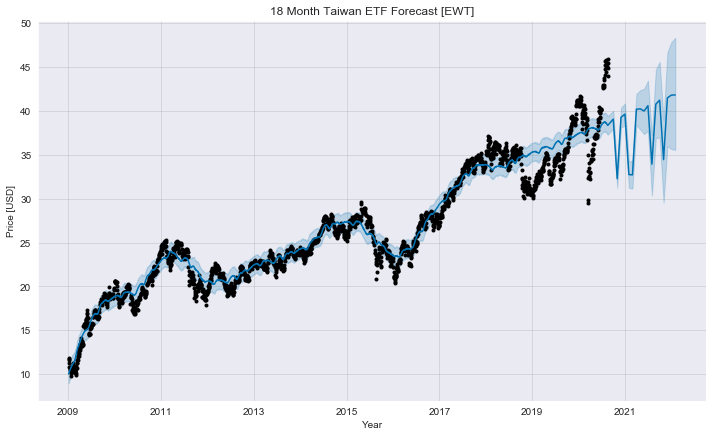

In [57]:
#Visualizing forecast
plt.figure(figsize = (20,10))
m.plot(etf_forecast, xlabel='Year',ylabel ='Price [USD]');
plt.title('18 Month Taiwan ETF Forecast [EWT]')

<Figure size 1440x720 with 0 Axes>

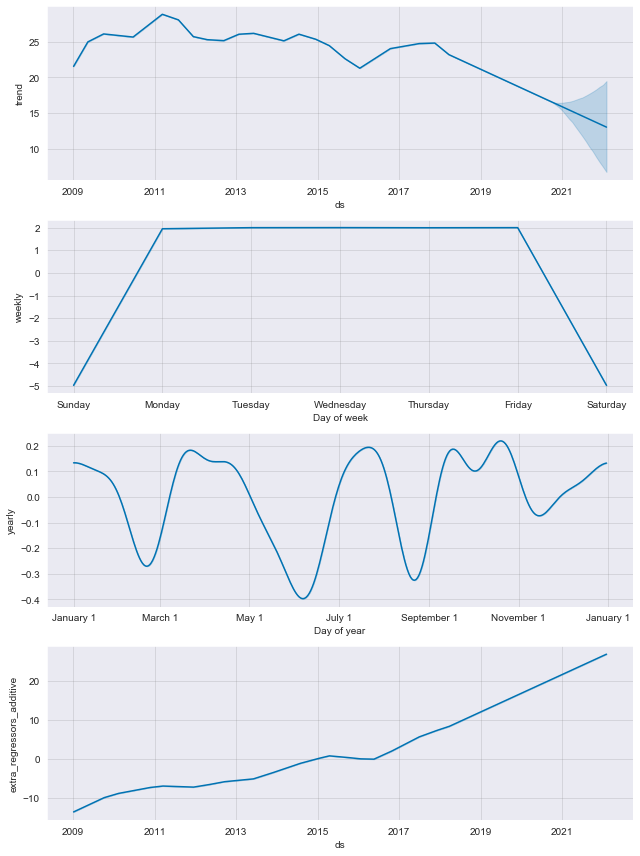

In [58]:
#Plotting forecast components
plt.figure(figsize = (20,10))
m.plot_components(etf_forecast);